In [164]:
import os
from dotenv import load_dotenv
from typing import Literal
from pprint import pprint
from langchain import hub
from typing import Literal,List
from typing_extensions import TypedDict
from langchain_cohere import CohereEmbeddings, ChatCohere
from langgraph.graph import END,START,StateGraph
from langchain.schema import Document
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import Field,BaseModel
from langchain_community.tools.tavily_search import TavilySearchResults



load_dotenv()
langchain_api = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
COHERE_API_KEY=os.getenv('COHERE_API_KEY')

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

### Index

In [165]:
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

embd = CohereEmbeddings(model="embed-multilingual-v3.0")

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512,chunk_overlap=0
)
splited_text = text_splitter.split_documents(docs_list)

vectorspace = Chroma.from_documents(
    embedding=embd,
    documents=splited_text,
)

retriever = vectorspace.as_retriever()


### Router

In [166]:
class web_search(BaseModel):
    """
    The internet. Use web_search for questions that are related to anything else than agents, prompt engineering, and adversarial attacks.
    """
    query: str=Field(description="The query to use when searching the internet")

class vectorstore(BaseModel):
    """
    A vectorstore containing documents related to agents, prompt engineering, and adversarial attacks. Use the vectorstore for questions on these topics.   
    """
    query: str=Field(description= "The query to use when searching the vectorstore")


preamble = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

llm = ChatCohere(model="command-a-03-2025",temperature=0)
structured_llm_router = llm.bind_tools(tools=[web_search,vectorstore],
                                       preamble=preamble)

route_prompt = ChatPromptTemplate(
    [
        ('user', "{question}")
    ]
)

question_router = route_prompt|structured_llm_router

response = question_router.invoke(
    {"question": "How are you?"}
)


### Retireval Grader

In [167]:
# class GradeDocuments(BaseModel):
#     binary_score: Literal["yes","no"] = Field(
#         description="Documents are relevant to the question: 'yes' or 'no'"
#     )

# preamble = """You are a grader assessing relevance of a retrieved document to a user question. \n
# If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
# Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""


# llm = ChatCohere(model="command-a-03-2025",temperature=0)
# structure_llm_grader = llm.with_structured_output(GradeDocuments,preamble=preamble)
# grader_prompt = ChatPromptTemplate.from_messages([
#     ('human',"Retrieved Document: \n\n{documents} \n\n User question: \n\n {question}"),
# ])
class GradeDocuments(BaseModel):
    binary_score : Literal["yes","no"] = Field(
        description="Documents are relevant to the question, 'yes', or 'no'"
    )

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system" , system),
        ("user", "Retrieved document: \n\n {document} \n\n User question: {question}")
    ]
)

retrieval_grader_chain = grader_prompt|structured_llm_grader
question = "What are the types of agent memory?"
docs = retriever.get_relevant_documents(question)[0].page_content
retrieval_grader_chain.invoke({"document": docs, "question": question})


/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


GradeDocuments(binary_score='yes')

### Generate

In [168]:
preamble = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', preamble),
        ('user', "Question: \n{question}\n\nContext:\n{documents}")
    ]
)

rag_generation = prompt|llm|StrOutputParser()

generation= rag_generation.invoke({'question': question, "documents":docs})

### Llm Fallback

In [ ]:
preamble = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

prompt = ChatPromptTemplate.from_messages(
    [
        ('system', preamble),
        ('user', "Question: \n{question} \n\nAnswer:")
    ]
)
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)


question = "hello"
rag_fall_back = prompt|llm|StrOutputParser()
generation=rag_fall_back.invoke({"question":question})


'Hello! How can I assist you today?'

### Hallucination Grader

In [170]:
class GradeHallucination(BaseModel):
    binary_score:Literal ["yes","no"] = Field(
        description="Answer is grounded in facts, 'yes' or 'no"
    )


preamble = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""


llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_hall_grader = llm.with_structured_output(GradeHallucination)

hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system",preamble),
    ("user","Set of Facts:\n\n {documents} \n\nLLM Generation:\n{generation}")
])
hellucination_rag = hallucination_prompt|structured_llm_hall_grader
hellucination_rag.invoke({'documents':docs,"generation":generation})

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


GradeHallucination(binary_score='yes')

### Answer Grader

In [171]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


preamble = """You are a grader assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""


structured_llm_grader_answer = llm.with_structured_output(GradeAnswer)

prompt = ChatPromptTemplate.from_messages(
    [
    ("system",preamble),
    ("user","Question:\n\n {question} \n\nLLM Generation:\n{generation}")
 
    ]
)
answer_grader_rag = prompt|structured_llm_grader_answer

answer_grader_rag.invoke({'question':question,"generation":generation})

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


GradeAnswer(binary_score='yes')

### Web Search Tool


In [172]:
web_search_tool = TavilySearchResults()

### Building Nodes

In [ ]:
class GraphState(TypedDict):

    question:str
    generation:str
    documents:List[str]

#----------------------------

def retrieve(state):
    print("---RETRIEVE---")

    question = state['question']
    documents = retriever.invoke(question)
    return {'documents':documents,'question':question}



def llm_fallback(state):
    print("---LLM Fallback---")

    question = state['question']
    generation = rag_fall_back.invoke({"question": question})
    return {"question": question, "generation": generation}


def generate(state):
    print("---GENERATE---")

    question = state['question']
    documents = state['documents']
    if not isinstance(documents, list):
        documents = [documents]
    generation = rag_generation.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation":generation}


def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    question = state['question']
    documents = state['documents']

    filtered_docs = []
    for d in documents:
        score = retrieval_grader_chain.invoke({"document": d.page_content, 
                                               "question": question}).binary_score
        if score=='yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def web_search(state):
    print("---WEB SEARCH---")

    question=state['question']
    docs = web_search_tool.invoke({"query":question})
    web_search = "\n".join(d['content'] for d in docs)
    web_result = Document(page_content=web_search)
    return{"documents":[web_result],"question":question}


def route_question(state):
    print("---ROUTE QUESTION---")

    question = state["question"]
    source = question_router.invoke({"question":question})

    if "tool_calls" not in source.additional_kwargs:
        print("---ROUTE QUESTION TO LLM---")
        return llm_fallback
    if len(source.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide source"

    datasource = source.additional_kwargs['tool_calls'][0]['function']['name'] 
    if datasource == "vectorspace":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    elif datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    else:
        print("---ROUTE QUESTION TO LLM---")
        return "llm_fallback"
    

    
def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")

    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, WEB SEARCH---")
        return "web_search"
    else:
        print("---DECISION: GENERATE---")
    return "generate"



def grade_generate_v_documents_and_question(state):

    print("---CHECK HALLUCINATIONS---")
    question = state['question']
    documents = state['documents']
    generation = state['generation']

    score = hellucination_rag.invoke({'documents':documents,"generation":generation})

    grade = score.binary_score

    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        score = answer_grader_rag.invoke({'question':question,"generation":generation})
        grade = score.binary_score
        print("---GRADE GENERATION vs QUESTION---")
        if grade == 'yes':
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else: 
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    



### Building Graph

In [189]:
workflow = StateGraph(GraphState)

workflow.add_node("retrieve",retrieve)
workflow.add_node("web_search",web_search)
workflow.add_node("grade_documents",grade_documents)
workflow.add_node("generate",generate)
workflow.add_node("llm_fallback",llm_fallback)

workflow.add_conditional_edges(
    START,
    route_question,
    {'web_search':'web_search',
     'llm_fallback':'llm_fallback',
     'vectorspace':'retrieve'}
)
workflow.add_edge("web_search","generate")
workflow.add_edge("retrieve",'grade_documents')
workflow.add_conditional_edges('grade_documents',decide_to_generate,
                               {"web_search":"web_search",
                                "generate":"generate"})

workflow.add_conditional_edges('generate',
                               grade_generate_v_documents_and_question,
                                   {
        "not supported": "generate",  
        "not useful": "web_search",  
        "useful": END,
    },)

workflow.add_edge("llm_fallback",END)
app =workflow.compile()

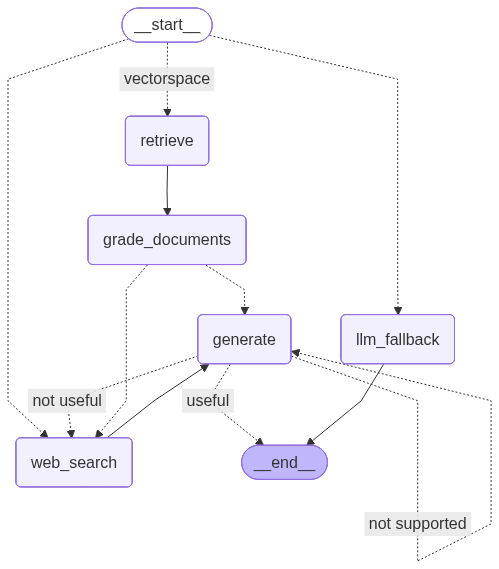

In [190]:
app

In [176]:
inputs = {
    "question": "What player are the Bears expected to draft first in the 2024 NFL draft?"
}

for output in app.stream(inputs):
    for key,val in output.items():
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
    pprint("\n---\n")
pprint(val["generation"])



---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The Chicago Bears are expected to draft Caleb Williams, a quarterback from '
 'USC, with their first overall pick in the 2024 NFL Draft. He is widely '
 'regarded as a generational talent and was the consensus top pick. This '
 "selection aligns with the Bears' goal of building long-term success at the "
 'quarterback position.')


In [191]:
inputs = {"question": "Hello, how are you today?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO LLM---
---LLM Fallback---
"Node 'llm_fallback':"
'\n---\n'
("I'm just a computer program, so I don't have feelings, but I'm here and "
 'ready to help you! How can I assist you today?')


In [163]:
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")

    pprint("\n---\n")

# Final generation
pprint(value["generation"])


---ROUTE QUESTION---
---ROUTE QUESTION TO LLM---
---LLM Fallback---
"Node 'llm_fallback':"
'\n---\n'
('The types of agent memory typically include short-term memory, which holds '
 'information temporarily for immediate tasks, and long-term memory, which '
 'stores information for extended periods. Additionally, there may be episodic '
 'memory, which recalls specific events, and semantic memory, which involves '
 'general knowledge and facts. These memory types help agents process '
 'information and learn from experiences.')
